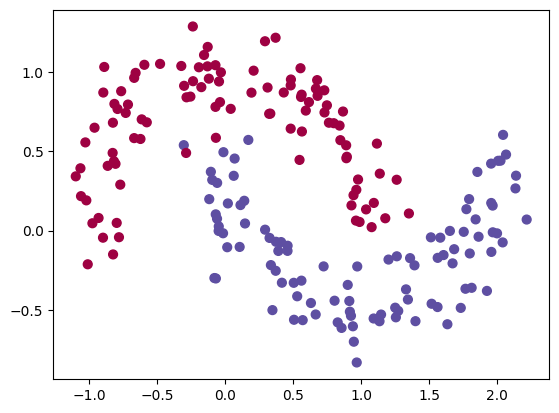

In [ ]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)
X, y = make_moons(n_samples=200, noise=0.15, random_state=True)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [ ]:
print(X.shape)
print(y)

(200, 2)
[0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1
 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1
 1 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [ ]:
class MultiplyGate:
    def forward(self,W, X):
        return np.dot(X, W)

    def backward(self, W, X, dZ):
        dW = np.dot(np.transpose(X), dZ)
        dX = np.dot(dZ, np.transpose(W))
        return dW, dX

class AddGate:
    def forward(self, X, b):
        return X + b

    def backward(self, X, b, dZ):
        dX = dZ * np.ones_like(X)
        db = np.dot(np.ones((1, dZ.shape[0]), dtype=np.float64), dZ)
        return db, dX

In [ ]:
class Sigmoid:
    def forward(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - output) * output * top_diff

class Tanh:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, X, top_diff):
        output = self.forward(X)
        return (1.0 - np.square(output)) * top_diff

In [ ]:
class Softmax:
    def predict(self, X):
        exp_scores = np.exp(X)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    def loss(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        corect_logprobs = -np.log(probs[:, 1]) * y - np.log(1 - probs[:, 1]) * (1 - y)
        data_loss = np.sum(corect_logprobs)
        return 1. / num_examples * data_loss

    def diff(self, X, y):
        num_examples = X.shape[0]
        probs = self.predict(X)
        probs[range(num_examples), y] -= 1
        return probs

In [ ]:
class Model:
    def __init__(self, layers_dim):
        self.b = []
        self.W = []
        self.loss = []
        layers_dim = [2, *layers_dim, 2]
        for i in range(len(layers_dim)-1):
            self.W.append(np.random.randn(layers_dim[i], layers_dim[i+1]) / np.sqrt(layers_dim[i]))
            self.b.append(np.random.randn(layers_dim[i+1]).reshape(1, layers_dim[i+1]))


    def calculate_loss(self, X, y):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        return softmaxOutput.loss(input, y)

    def predict(self, X):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        input = X
        for i in range(len(self.W)):
            mul = mulGate.forward(self.W[i], input)
            add = addGate.forward(mul, self.b[i])
            input = layer.forward(add)

        probs = softmaxOutput.predict(input)
        return np.argmax(probs, axis=1)

    def train(self, X, y, num_passes=20000, epsilon=0.01, reg_lambda=0.01, print_loss=False):
        mulGate = MultiplyGate()
        addGate = AddGate()
        layer = Tanh()
        softmaxOutput = Softmax()

        for epoch in range(num_passes):
            # Forward propagation
            input = X
            forward = [(None, None, input)]
            for i in range(len(self.W)):
                mul = mulGate.forward(self.W[i], input)
                add = addGate.forward(mul, self.b[i])
                input = layer.forward(add)
                forward.append((mul, add, input))

            # Back propagation
            dtanh = softmaxOutput.diff(forward[len(forward)-1][2], y)
            self.loss.append(softmaxOutput.loss(forward[len(forward)-1][2], y))
            for i in range(len(forward)-1, 0, -1):
                dadd = layer.backward(forward[i][1], dtanh)
                db, dmul = addGate.backward(forward[i][0], self.b[i-1], dadd)
                dW, dtanh = mulGate.backward(self.W[i-1], forward[i-1][2], dmul)
                # Add regularization terms (b1 and b2 don't have regularization terms)
                dW += reg_lambda * self.W[i-1]
                # Gradient descent parameter update
                self.b[i-1] -= epsilon * db
                self.W[i-1] -= epsilon * dW

            if print_loss and epoch % 1000 == 0:
                print("Loss after iteration %i: %f" %(epoch, self.calculate_loss(X, y)))
        plt.plot(self.loss)
        plt.show()

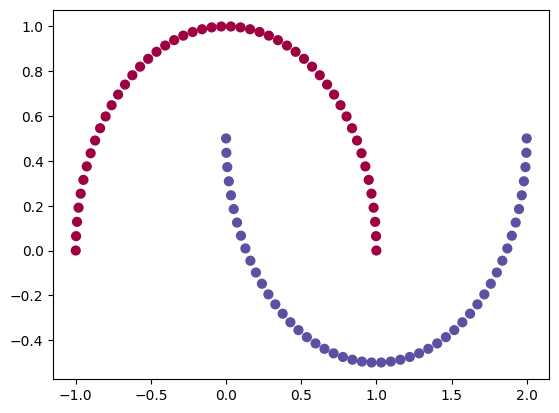

Loss after iteration 0: 0.659523
Loss after iteration 1000: 0.127450
Loss after iteration 2000: 0.127306
Loss after iteration 3000: 0.127277
Loss after iteration 4000: 0.127267
Loss after iteration 5000: 0.127262
Loss after iteration 6000: 0.127258
Loss after iteration 7000: 0.127256
Loss after iteration 8000: 0.127254
Loss after iteration 9000: 0.127253
Loss after iteration 10000: 0.127251
Loss after iteration 11000: 0.127250
Loss after iteration 12000: 0.127248
Loss after iteration 13000: 0.127247
Loss after iteration 14000: 0.127246
Loss after iteration 15000: 0.127245
Loss after iteration 16000: 0.127244
Loss after iteration 17000: 0.127243
Loss after iteration 18000: 0.127242
Loss after iteration 19000: 0.127242
Loss after iteration 20000: 0.127241
Loss after iteration 21000: 0.127240
Loss after iteration 22000: 0.127240
Loss after iteration 23000: 0.127239
Loss after iteration 24000: 0.127238
Loss after iteration 25000: 0.127238
Loss after iteration 26000: 0.127237
Loss after ite

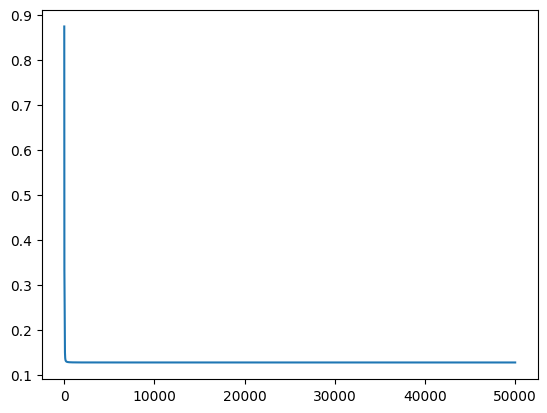

<class '__main__.Softmax'>


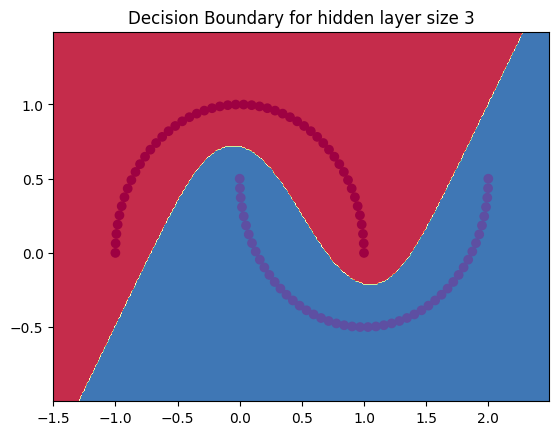

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
# import mlnn
# from utils import plot_decision_boundary

# Generate a dataset and plot it
np.random.seed(0)
X, y = make_moons(n_samples=100, noise=0.0, random_state=None)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

layers_dim = [5,5]

model = Model(layers_dim)
model.train(X, y, num_passes=50000, epsilon=0.01, reg_lambda=0.01, print_loss=True)

# Plot the decision boundary
print(Softmax)
plot_decision_boundary(lambda x: model.predict(x), X, y)
plt.title("Decision Boundary for hidden layer size 3")
plt.show()